# Part 0: Set up
Import packages

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set the style & colors for the plots
sns.set_style('darkgrid')
_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

---
# Part 1: Generate data

- Continuous data
- Normal distributed

In [42]:
np.random.seed(42)
true_mean_C, true_sigma_C = 20, 3 # Parameters for Group C (Control)
true_mean_T, true_sigma_T = 20.5, 3 # Parameters for Group T (Treatment)
N = 10000

data_C = np.random.normal(true_mean_C, true_sigma_C, N)
data_T = np.random.normal(true_mean_T, true_sigma_T, N)

Define:
- $\delta = \mu_T - \mu_C$
- $\sigma = \frac{\sigma_T}{n_T} + \frac{\sigma_C}{n_C}$

In [43]:
# Derive difference
delta = data_T.mean() - data_C.mean()
sigma = data_T.var()/N + data_C.var()/N

print(f"delta: {delta:.3f}, sigma: {sigma}")

delta: 0.547, sigma: 0.0018078816392912652


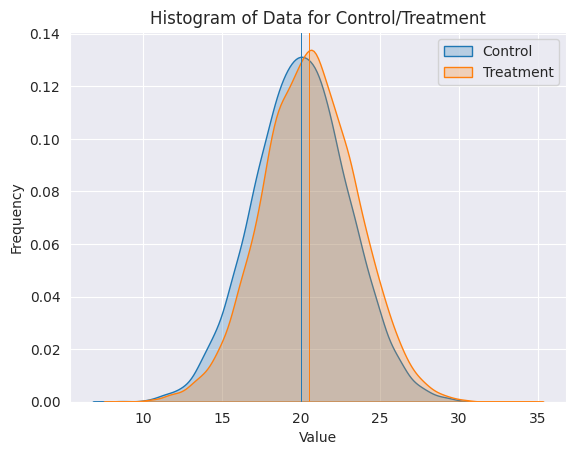

In [44]:
# Histogram of sampled data
sns.kdeplot(data_C, color = _colors[0], label = "Control", fill = True)
sns.kdeplot(data_T, color = _colors[1], label = "Treatment", fill = True)
plt.axvline(x = true_mean_C, color = _colors[0], linewidth = 0.7, linestyle = "-")
plt.axvline(x = true_mean_T, color = _colors[1], linewidth = 0.7, linestyle = "-")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Control/Treatment')
plt.legend()
plt.show()

---
# Part 2: Specify Priors

Assume Conjugate normal priors with distinct means and variances

In [45]:
# Control
delta_h0 = 0
sigma_h0 = 5

# Treatment
delta_h1 = 0.5
sigma_h1 = 5

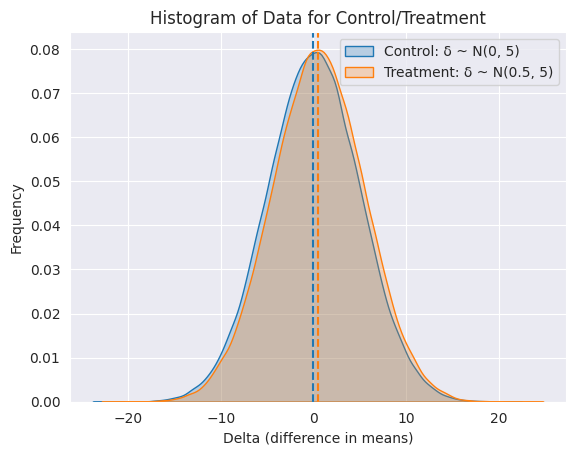

In [46]:
# Sample from prior distribution
prior_samples_control = np.random.normal(delta_h0, sigma_h0, 100000)
prior_samples_treatment = np.random.normal(delta_h1, sigma_h1, 100000)

# Histogram of sampled data
sns.kdeplot(prior_samples_control, fill = True, label = f'Control: δ ~ N({delta_h0}, {sigma_h0})')
sns.kdeplot(prior_samples_treatment, fill = True, label = f'Treatment: δ ~ N({delta_h1}, {sigma_h1})')
plt.axvline(x = delta_h0, color = _colors[0], linestyle = "--")
plt.axvline(x = delta_h1, color = _colors[1], linestyle = "--")
plt.xlabel('Delta (difference in means)')
plt.ylabel('Frequency')
plt.title('Histogram of Data for Control/Treatment')
plt.legend()
plt.show()

---
# Part 3: Bayes factor

Marginal likelihood ratio with the following hypotheses:

$$ \mathbf{H_0}: \delta \leq 0 \qquad\quad \mathbf{H_1}: \delta > 0 $$


In [47]:
import numpy as np
from scipy.stats import norm

def phi(x):
    """Cumulative distribution function for standard normal distribution."""
    return norm.cdf(x)

def bayes_factor(y, delta_h0, sigma_h0, delta_h1, sigma_h1, sigma):
    """Compute the Bayes Factor given the data and hypotheses."""

    # Compute shared terms
    delta_prime = (sigma_h0**2 * y + sigma**2 * delta_h0) / (sigma_h0**2 + sigma**2)
    sigma_1_prime = np.sqrt((1 / (1/sigma_h0**2 + 1/sigma**2)))

    # Marginal likelihood under H0
    p_y_h0 = 1 - phi((delta_prime - y) / sigma_1_prime)

    # Marginal likelihood under H1
    p_y_h1 = phi((delta_prime - y) / sigma_1_prime)

    # Ratio of normalizing constants
    normalizing_ratio = (phi(-delta_h0/sigma_h0) / (1 - phi(-delta_h1/sigma_h1)))

    # Variance ratio
    variance_ratio = np.sqrt((sigma_h0**2 + sigma**2) / (sigma_h1**2 + sigma**2))

    # Exponential term
    exp_term = np.exp(- (1/(2*sigma**2 + 2*sigma_1_prime**2)) * (delta_h1 - delta)**2 + (1/(2*sigma**2 + 2*sigma_1_prime**2)) * (delta_h0 - delta)**2)

    # Compute Bayes Factor
    BF = (p_y_h1 / p_y_h0) * normalizing_ratio * variance_ratio * exp_term

    return BF

In [48]:
# Bayes factor
print("Bayes Factor:", bayes_factor(delta, delta_h0, sigma_h0, delta_h1, sigma_h1, sigma))

# Source data
print(f"""
Overview of Variables:
----------------------

Data:
- Observed difference (y): {delta}
- Standard deviation of observed data (sigma): {sigma}

Priors:
Null Hypothesis (H0):
- Mean difference (delta_h0): {delta_h0}
- Standard deviation (sigma_h0): {sigma_h0}

Alternative Hypothesis (H1):
- Mean difference (delta_h1): {delta_h1}
- Standard deviation (sigma_h1): {sigma_h1}
""")


Bayes Factor: inf

Overview of Variables:
----------------------

Data:
- Observed difference (y): 0.54701010929994
- Standard deviation of observed data (sigma): 0.0018078816392912652

Priors:
Null Hypothesis (H0):
- Mean difference (delta_h0): 0
- Standard deviation (sigma_h0): 5

Alternative Hypothesis (H1):
- Mean difference (delta_h1): 0.5
- Standard deviation (sigma_h1): 5



<ipython-input-47-dcd132c5832d>:28: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(- (1/(2*sigma**2 + 2*sigma_1_prime**2)) * (delta_h1 - delta)**2 + (1/(2*sigma**2 + 2*sigma_1_prime**2)) * (delta_h0 - delta)**2)


## Early stopping

In [49]:
# Settings
k = 30
interim_test_interval = 5
print_es_progress = False # Print progress

# Initialise
bf, n_observed = 0, 10 # first n_observed is kind of cold start n
interim_tests = []


while n_observed <= N:
    # Get delta & sigma (given n_observed)
    delta_n = data_T[:n_observed].mean() - data_C[:n_observed].mean()
    sigma_n = data_C[:n_observed].var()/n_observed + data_T[:n_observed].var()/n_observed

    # Get & store (beta) Bayes Factor
    bf = bayes_factor(delta_n, delta_h0, sigma_h0, delta_h1, sigma_h1, sigma_n)
    interim_tests.append((n_observed, bf))

    # option to print progress if desired
    if print_es_progress == True:
        print(f"n: {n_observed}/{N}, BF: {bayes_factor}")

    # Stopping criteria
    if (bf > k or bf < 1/k):
        break

    # Extend sample & get conversions
    n_observed += interim_test_interval

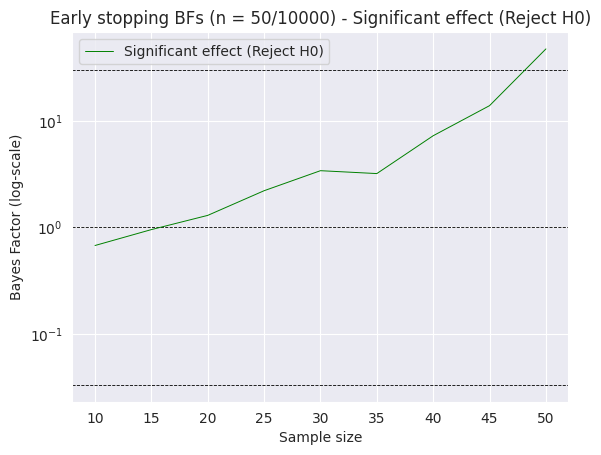


Overview of Variables:
----------------------

Fixed Horizon (n = 10000):
- Observed difference: 0.54701010929994
- Standard deviation:  0.0018078816392912652

Fixed Horizon (n = 50):
- Observed difference: 1.557356601067113
- Standard deviation:  0.28746577877567603
- Bayes factor: 47.29920575053085

Priors:
Null Hypothesis (H0):
- Mean difference (delta_h0): 0
- Standard deviation (sigma_h0): 5

Alternative Hypothesis (H1):
- Mean difference (delta_h1): 0.5
- Standard deviation (sigma_h1): 5



In [50]:
def plot_early_stopping(interim_tests):
    # plot stopping criteria
    plt.axhline(y = 1, color = "black", linestyle = "--", linewidth = "0.6")
    plt.axhline(y = k, color = "black", linestyle = "--", linewidth = "0.6")
    plt.axhline(y = 1/k, color = "black", linestyle = "--", linewidth = "0.6")

    # Plot interim testing Bayes-Factor development
    if interim_tests[-1][1] > 1: # Reject H0 (Effect discovery)
        color_i = "green"
        conclusion = "Significant effect (Reject H0)"
    else: # Accept H0 (No effect)
        color_i = "red"
        conclusion = "No effect (Accept H0)"

    x, y = zip(*interim_tests)
    plt.plot(x, y, linestyle = "-", linewidth = 0.7, color = color_i, label = conclusion)

    # Set the y-axis to log scale
    plt.yscale('log')
    plt.xlabel("Sample size")
    plt.ylabel("Bayes Factor (log-scale)")
    plt.legend()
    plt.title(f"Early stopping BFs (n = {interim_tests[-1][0]}/{N}) - {conclusion}")
    plt.show()

plot_early_stopping(interim_tests)

# Source data
print(f"""
Overview of Variables:
----------------------

Fixed Horizon (n = {N}):
- Observed difference: {delta}
- Standard deviation:  {sigma}

Fixed Horizon (n = {n_observed}):
- Observed difference: {delta_n}
- Standard deviation:  {sigma_n}
- Bayes factor: {bf}

Priors:
Null Hypothesis (H0):
- Mean difference (delta_h0): {delta_h0}
- Standard deviation (sigma_h0): {sigma_h0}

Alternative Hypothesis (H1):
- Mean difference (delta_h1): {delta_h1}
- Standard deviation (sigma_h1): {sigma_h1}
""")

In [51]:
interim_tests

[(10, 0.6772583935182215),
 (15, 0.9549828178945833),
 (20, 1.2981736472865844),
 (25, 2.2114551029280443),
 (30, 3.40880450317676),
 (35, 3.202761945763805),
 (40, 7.253024167531672),
 (45, 13.889674422513025),
 (50, 47.29920575053085)]

# Alternative method - Bayes Factor calculation

In [52]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad

# Calculating mu' and sigma' for the convolution
delta_prime = lambda sigma_prior, delta_prior: (sigma_prior**2 * delta+ sigma**2 * delta_prior) / (sigma**2 + sigma_prior**2)
sigma_prime = lambda sigma_prior: np.sqrt((sigma**2 * sigma_prior**2) / (sigma**2 + sigma_prior**2))

delta_prime_h0 = delta_prime(sigma_h0, delta_h0)
sigma_prime_h0 = sigma_prime(sigma_h0)

delta_prime_h1 = delta_prime(sigma_h1, delta_h1)
sigma_prime_h1 = sigma_prime(sigma_h1)

# Integrands for the two hypotheses
integrand_h0 = lambda mu: np.exp(-0.5 * (((delta - mu) / sigma)**2 + ((mu - delta_h0) / sigma_h0)**2))
integrand_h1 = lambda mu: np.exp(-0.5 * (((delta - mu) / sigma)**2 + ((mu - delta_h1) / sigma_h1)**2))

# Compute the marginal likelihood for H0 and H1 using convolution properties
P_y_H0, _ = quad(integrand_h0, -np.inf, 0)
P_y_H1, _ = quad(integrand_h1, 0, np.inf)

print("P(y|H0):", P_y_H0)
print("P(y|H1):", P_y_H1)


P(y|H0): 0.0
P(y|H1): 0.0


In [53]:
# Bayes factor
print("Bayes Factor:", P_y_H1 / P_y_H0)

# Source data
print(f"""
Overview of Variables:
----------------------

Data:
- Observed difference (y): {delta}
- Standard deviation of observed data (sigma): {sigma}

Priors:
Null Hypothesis (H0):
- Mean difference (delta_h0): {delta_h0}
- Standard deviation (sigma_h0): {sigma_h0}

Alternative Hypothesis (H1):
- Mean difference (delta_h1): {delta_h1}
- Standard deviation (sigma_h1): {sigma_h1}
""")


ZeroDivisionError: ignored